In [1]:
import sys
sys.path.append(r"/mnt/ceph/users/tudomlumleart/00_VirtualEnvironments/teeu/lib/python3.10/site-packages")
sys.path.append(r"/mnt/home/tudomlumleart/.local/lib/python3.10/site-packages/")
sys.path.append(r"/mnt/home/tudomlumleart/ceph/00_VirtualEnvironments/jupyter-gpu/lib/python3.10/site-packages")
from utils import *
from functions import *
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture 
import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import validation_curve

os.environ['TF_ENABLE_ONEDNN_OPTS']='0'

from sklearn.metrics import adjusted_mutual_info_score

import os
import scipy.io

2024-08-05 14:28:02.701634: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-05 14:28:02.730567: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI AVX512_BF16, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load dataset from file
folder_path = '/mnt/home/tudomlumleart/ceph/05_Sox9Dataset/'

# List all .mat files in the folder and load them
cnc_maps = scipy.io.loadmat(folder_path + 'cncMaps.mat')['cncMaps'][:80, :80, :]
esc_maps = scipy.io.loadmat(folder_path + 'escMaps.mat')['escMaps'][:80, :80, :]

# Load polys data and then perform linear interpolation
# List all .mat files in the folder and load them
cnc_polys = scipy.io.loadmat(folder_path + 'cncPols.mat')['cncPols'][:80, :, :]
esc_polys = scipy.io.loadmat(folder_path + 'escPols.mat')['escPols'][:80, :, :]


In [3]:
def interpolate_polymers(polys):
    num_probes, num_coords, num_cells = polys.shape
    new_polys = np.zeros((num_probes, num_coords, num_cells))
    for c in range(num_cells):
        curr_cells = polys[:, :, c]
        for x in range(num_coords):
            curr_coords = curr_cells[:, x]
            missing_indices = np.isnan(curr_coords)
            valid_indices = ~missing_indices
            interp_coords = np.interp(np.flatnonzero(missing_indices), np.flatnonzero(valid_indices), curr_coords[valid_indices])
            new_polys[missing_indices, x, c] = interp_coords
            new_polys[valid_indices, x, c] = curr_coords[valid_indices]
    return new_polys

In [4]:
esc_polys_interp = interpolate_polymers(esc_polys)
cnc_polys_interp = interpolate_polymers(cnc_polys)

esc_maps_interp = np.array([squareform(pdist(esc_polys_interp[:, :, i])) for i in range(esc_polys_interp.shape[2])])
cnc_maps_interp = np.array([squareform(pdist(cnc_polys_interp[:, :, i])) for i in range(cnc_polys_interp.shape[2])])
esc_maps_interp_flat = np.array([x.flatten() for x in esc_maps_interp])
cnc_maps_interp_flat = np.array([x.flatten() for x in cnc_maps_interp])
all_maps_interp_flat = np.concatenate((esc_maps_interp_flat, cnc_maps_interp_flat), axis=0)

In [5]:
from umap import UMAP

In [6]:
umap = UMAP(n_components=2)
umap.fit(all_maps_interp_flat)
esc_maps_umap = umap.transform(esc_maps_interp_flat)
cnc_maps_umap = umap.transform(cnc_maps_interp_flat)

In [11]:
# Convert the principal components into a DataFrame
# add a column for the label
esc_df = pd.DataFrame(esc_maps_umap, columns=['UMAP1', 'UMAP2'])
esc_df['label'] = 'ESC'
cnc_df = pd.DataFrame(cnc_maps_umap, columns=['UMAP1', 'UMAP2'])
cnc_df['label'] = 'CNC'
all_df = pd.concat([esc_df, cnc_df], axis=0)

In [9]:
save_dir = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/figures/20240805/'

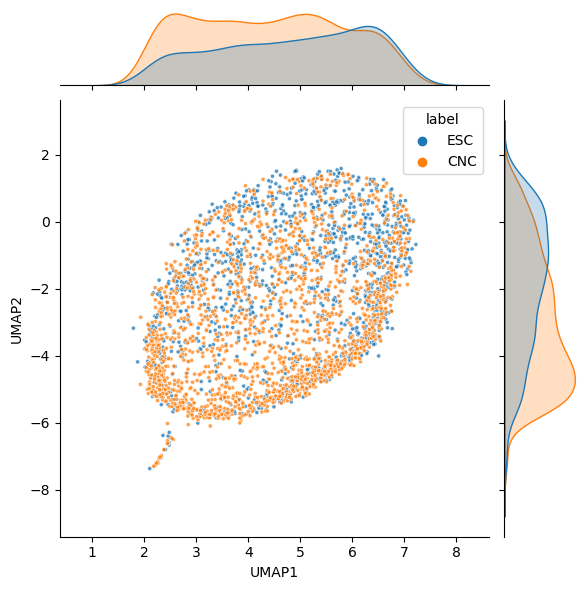

In [12]:
sns.jointplot(x='UMAP1', y='UMAP2', data=all_df, marker='.', hue='label', alpha=0.75)
plt.savefig(save_dir + 'umap_2d.png', dpi=300, bbox_inches='tight')

In [13]:
# Find 0.05 and 0.95 quantiles of PC1 and PC2 data
umap1_05 = all_df['UMAP1'].quantile(0.05)
umap1_95 = all_df['UMAP1'].quantile(0.95)
umap2_05 = all_df['UMAP2'].quantile(0.05)
umap2_95 = all_df['UMAP2'].quantile(0.95)

In [14]:
umap1_grid = np.linspace(umap1_05, umap1_95, 10)
umap2_grid = np.linspace(umap2_05, umap2_95, 10)

In [15]:
# Generate combination of pc1 and pc2 values
umap1_grid, umap2_grid = np.meshgrid(umap1_grid, umap2_grid)

In [20]:
# put this into a dataframe
umap1_grid_flat = umap1_grid.flatten()
umap2_grid_flat = umap2_grid.flatten()
umap1_umap2_df = pd.DataFrame({'UMAP1': umap1_grid_flat, 'UMAP2': umap2_grid_flat})
umap1_umap2_df['label'] = 'metastructures'

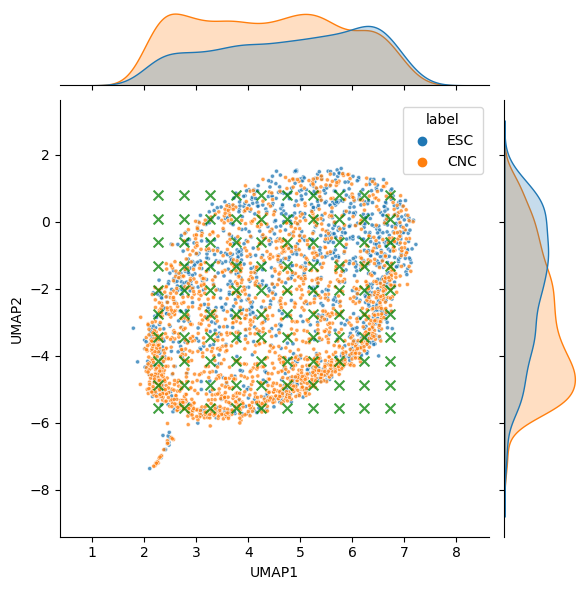

In [18]:
sns.jointplot(x='UMAP1', y='UMAP2', data=all_df, marker='.', hue='label', alpha=0.75)
plt.scatter(umap1_grid_flat, umap2_grid_flat, marker='x', color='green', s=50, alpha=0.75)
plt.savefig(save_dir + 'umap_2d_with_metastructure.png', dpi=300, bbox_inches='tight')

In [21]:
# Sort PC2 in descending order while keeping PC1 in ascending order
umap1_umap2_df = umap1_umap2_df.sort_values(by=['UMAP1', 'UMAP2'], ascending=[True, False], ignore_index=True)

In [22]:
metastr_from_umap = umap.inverse_transform(umap1_umap2_df[['UMAP1', 'UMAP2']])

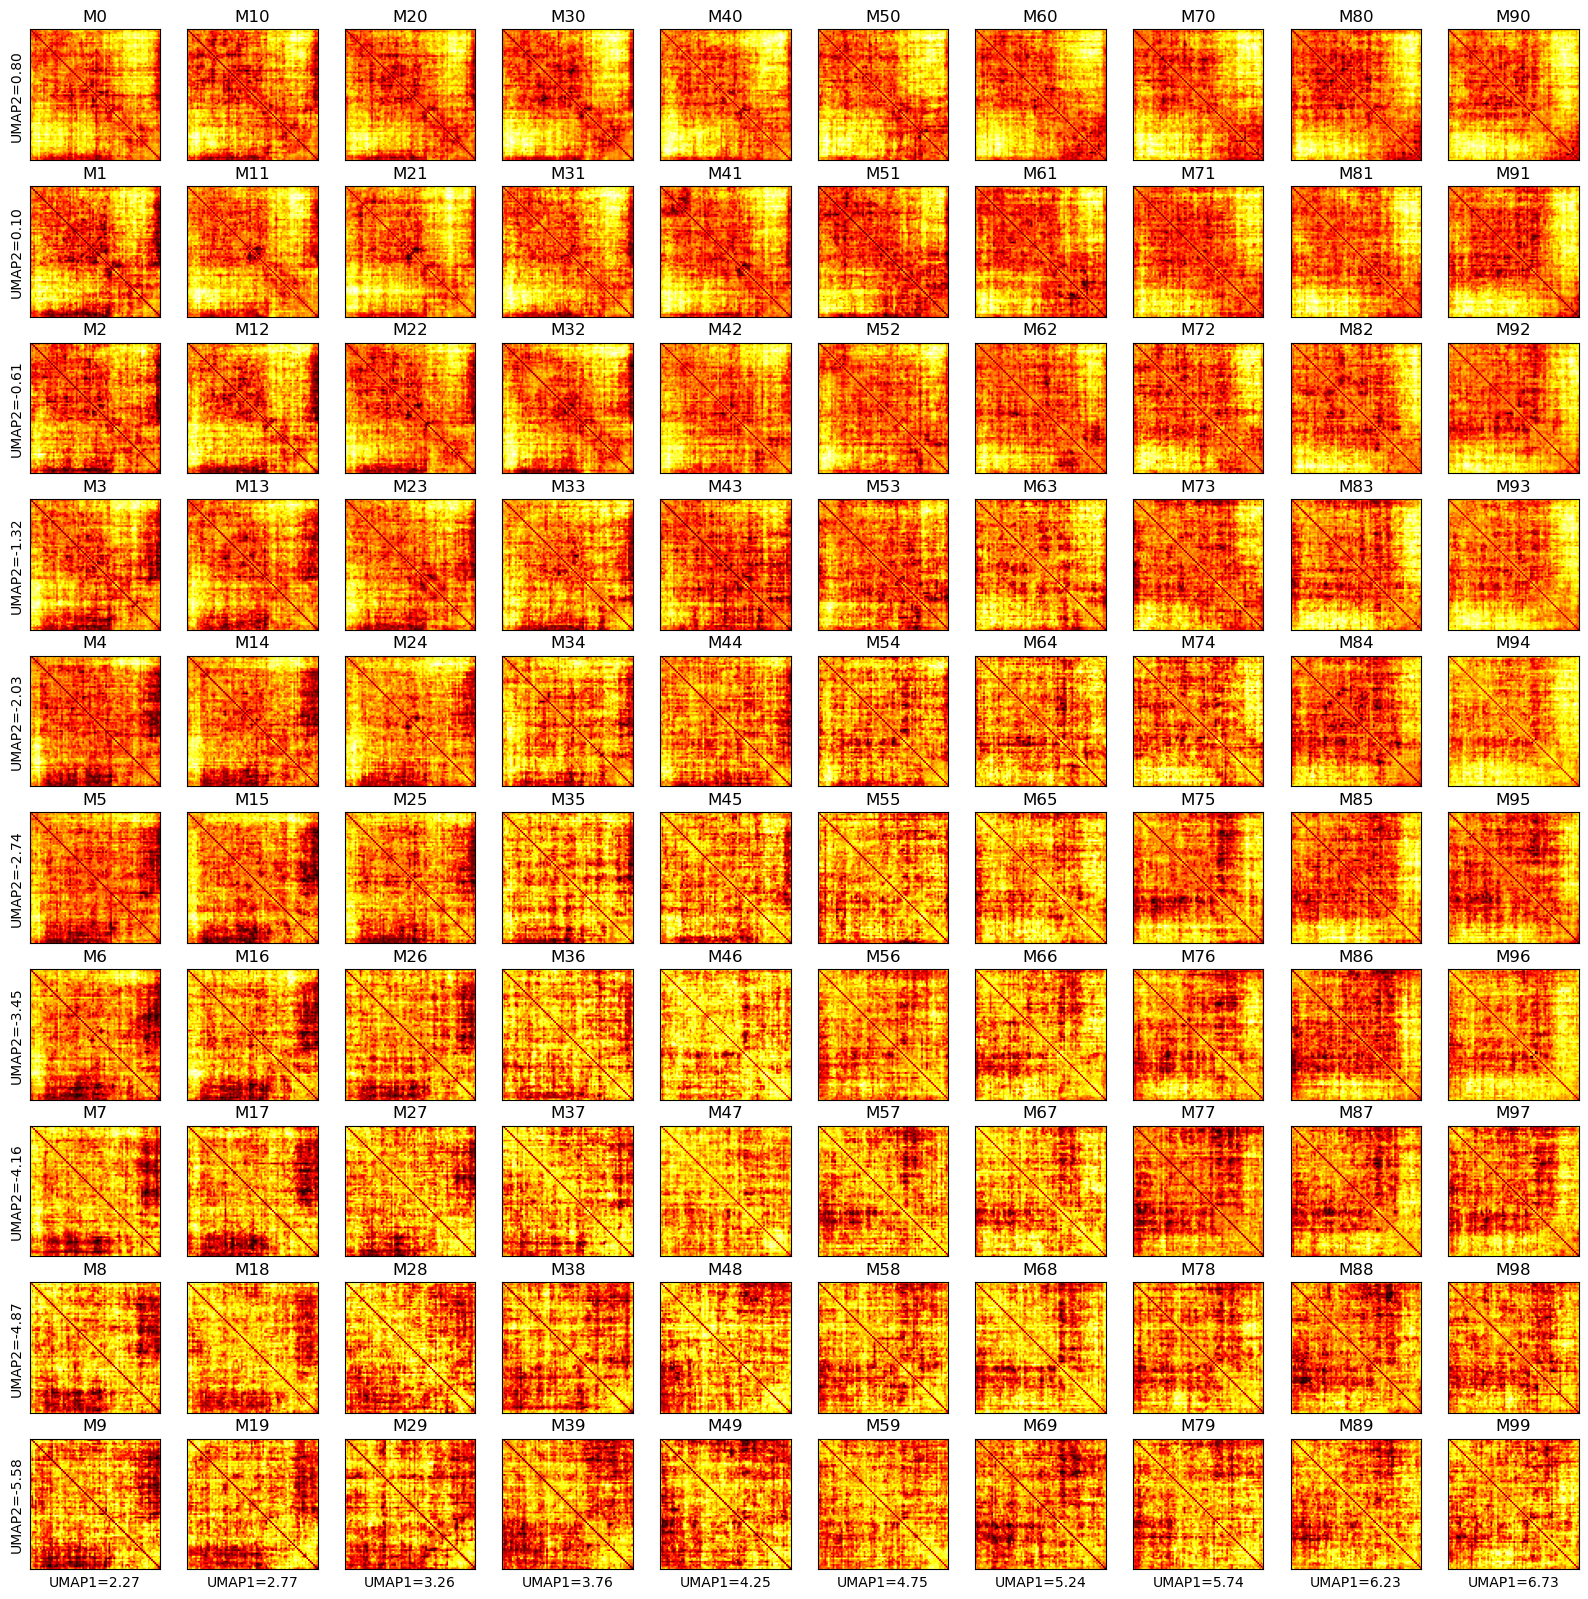

In [24]:
# Plot 10 x 10 grid of metastructures based on PC1 and PC2 
fig, axs = plt.subplots(10, 10, figsize=(20, 20))
for i in range(100):
    ax = ax=axs[i%10, i//10]
    metastr = metastr_from_umap[i]
    metastr = metastr.reshape((80, 80))
    ax.imshow(metastr, cmap='hot')
    ax.set_title(f'M{i}')
    # axs[i//10, i%10].axis('off')
    # if ax is in the first col, add a y label
    if i // 10 == 0:
        ax.set_ylabel(f'UMAP2={umap1_umap2_df.iloc[i, 1]:.2f}')
    # if ax is in the last row, add a x label
    if i % 10 == 9:
        ax.set_xlabel(f'UMAP1={umap1_umap2_df.iloc[i, 0]:.2f}')
        
    # Remove ticks by setting them to an empty list
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.savefig(save_dir + 'metastructure_maps_sorted_by_umap.png', dpi=300, bbox_inches='tight')